# EECS731
## Project 5- World Wide Products

Shipping and delivering to a place near you
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the product demand data set from
https://www.kaggle.com/felixzhao/productdemandforecasting
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more forecasting models to determine the demand for a particular product using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub
<br>
***

In [1]:
from pandas import read_csv, Series, to_datetime, to_timedelta, concat, isnull, DatetimeIndex
from numpy import isnan, any, all, isfinite, where, column_stack,ravel
from itertools import product

# Feature engineering and selection
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose 

# models
from fbprophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# plots
from matplotlib.pyplot import figure , imshow, axis, show, plot, title, xlabel, ylabel, legend
from matplotlib.patches import Patch
from seaborn import heatmap

Importing plotly failed. Interactive plots will not work.


In [2]:
df = read_csv("../data/raw/Historical Product Demand.csv")
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [4]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [5]:
print(f"There are {len(df['Product_Code'].unique())} unique values of Product_Code")
print(f"There are {len(df['Warehouse'].unique())} unique values of Warehouse" )
print(f"There are {len(df['Product_Category'].unique())} unique values of Product_Category")

There are 2160 unique values of Product_Code
There are 4 unique values of Warehouse
There are 33 unique values of Product_Category


## Let's look deeper at the datasets given

Column | Definition
-----| ---------
Product_Code | Format of Product_
Warehouse | Only has 4 types of warehouse with code Whse_
Product_Category | Format of Category_
Date | Date
Order_Demand | Number of order demanded

<br>

Looking at the above information:
- Column/s with null values
    - Date 
- Remove Product_ and Category_ and it will only be numbers (int column type). ***Do not need labelencoder***
- Order_Demand should be int type
- Date should be datetime type
- There are only 4 warehouse. ***Use LabelEncoder***
<br>

# Let's start data cleaning
***
***Remove nan from columns***

In [6]:
df.dropna(subset=["Date"], inplace=True)

**Delete product_ and category_ and change to interger type***
- Do not need LabelEncoder
- Easier to search in the future because LabelEncoder will replace with its own number
- Interger column will solve problem such as product_0993 and product_00993 

In [7]:
# strip and lowercase all string types cols
df = df.apply(lambda x: x.str.strip().str.lower() if x.dtype == "object" else x)
# Delete product_ and category_ so there is only numbers left
df["Product_Code"] = df["Product_Code"].str.split(r"product_").str.get(1).astype(int)
df["Product_Category"] = df["Product_Category"].str.split(r"category_").str.get(1).astype(int)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,993,whse_j,28,2012/7/27,100
1,979,whse_j,28,2012/1/19,500
2,979,whse_j,28,2012/2/3,500
3,979,whse_j,28,2012/2/9,500
4,979,whse_j,28,2012/3/2,500


***LabelEncoder Warehouse and Change Date to date type*** 

In [8]:
df["Warehouse"] = LabelEncoder().fit_transform(df["Warehouse"].astype(str))
df["Date"] = to_datetime(df["Date"])

***Remove ( ) from Order_Demand first before changing to int column type***

In [9]:
df.iloc[112289]

Product_Code                       2169
Warehouse                             0
Product_Category                     24
Date                2012-08-09 00:00:00
Order_Demand                        (1)
Name: 112290, dtype: object

In [10]:
df['Order_Demand'] = df['Order_Demand'].str.strip('()').astype(int)
df.iloc[112289]

Product_Code                       2169
Warehouse                             0
Product_Category                     24
Date                2012-08-09 00:00:00
Order_Demand                          1
Name: 112290, dtype: object

Brackets are succesfully deleted!!

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  int64         
 1   Warehouse         1037336 non-null  int64         
 2   Product_Category  1037336 non-null  int64         
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 47.5 MB


**Sort date from oldest to latest***

In [12]:
df.sort_values(by=["Date"],ascending=True, inplace=True)
df.reset_index(drop=True)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,965,0,6,2011-01-08,2
1,1724,0,3,2011-05-31,108
2,1521,3,19,2011-06-24,85000
3,1521,3,19,2011-06-24,7000
4,1507,1,19,2011-09-02,1250
...,...,...,...,...,...
1037331,1710,2,26,2017-01-06,15
1037332,1359,2,19,2017-01-06,100000
1037333,250,1,7,2017-01-09,148
1037334,1904,1,19,2017-01-09,4000


In [13]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,965,0,6,2011-01-08,2
72252,1724,0,3,2011-05-31,108
8431,1521,3,19,2011-06-24,85000
8432,1521,3,19,2011-06-24,7000
72669,1507,1,19,2011-09-02,1250


Data cleaning is done!!

# Understand more about the data with visualisation

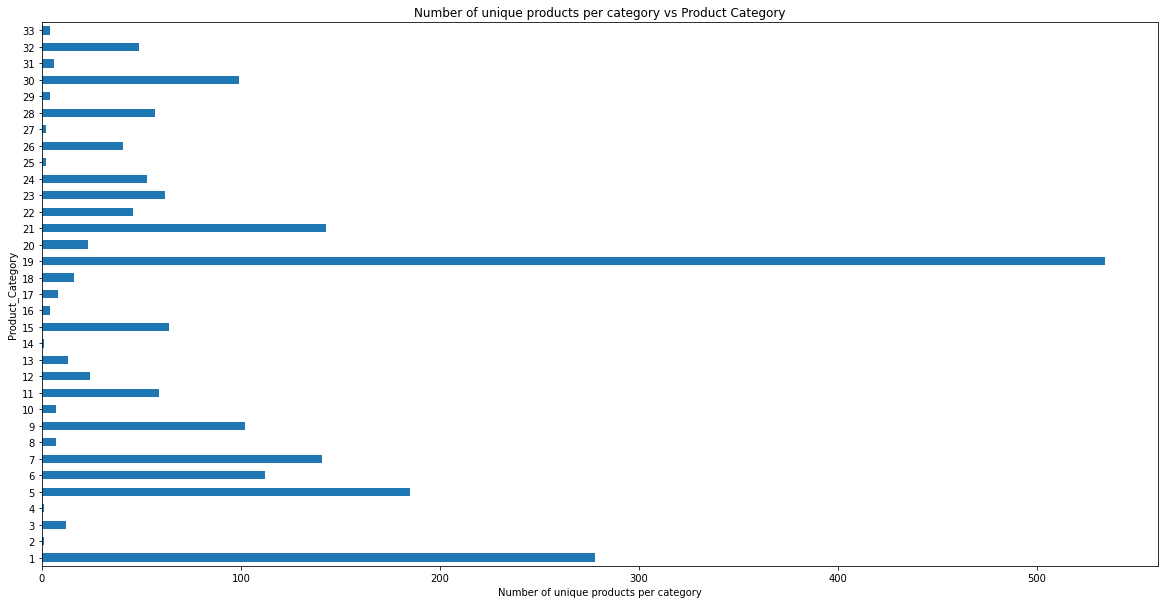

In [14]:
# Group according to Product_Category
df_n_category = df.groupby("Product_Category")
# Check how many unique product in each category
df_n_category["Product_Code"].nunique().plot(kind="barh", figsize=(20,10))
title("Number of unique products per category vs Product Category")
xlabel("Number of unique products per category")
show()

Category 19 has the most unique numbers of products

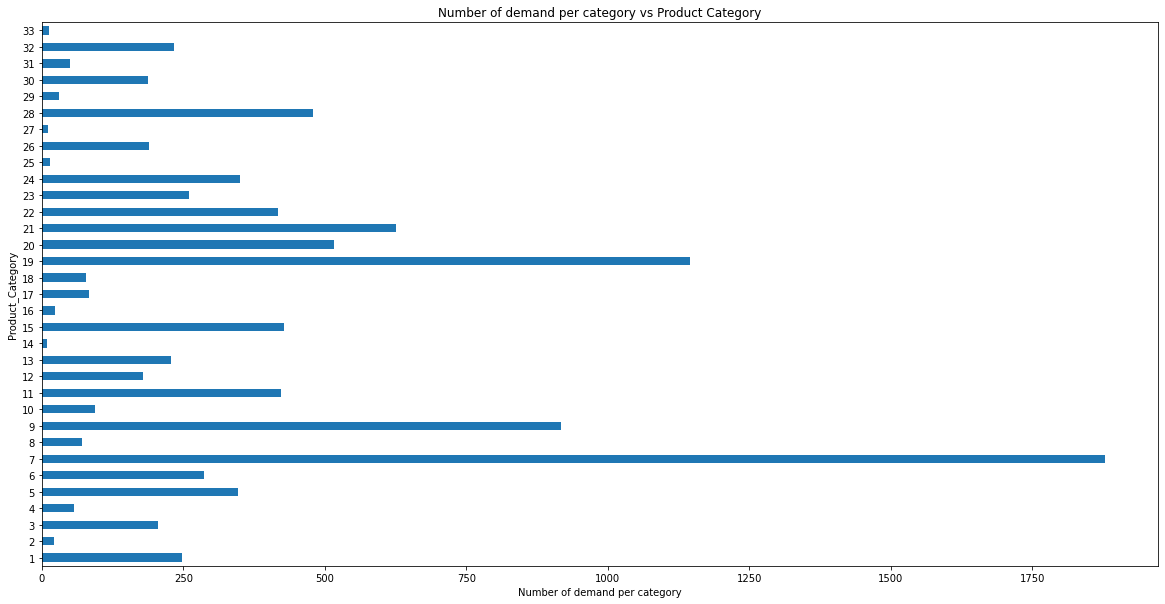

In [15]:
df_n_category['Order_Demand'].nunique().plot(kind='barh',figsize=(20,10))

title("Number of demand per category vs Product Category")
xlabel("Number of demand per category")
show()

Most demand is actually category 6!

***Plot the average weekly demand***

In [16]:
series = df[["Date", "Order_Demand"]]
series.set_index("Date", inplace=True)

# Group according to weekly frequency
series = series.resample("W").mean()
series.dropna(inplace=True)
series.head()

,Order_Demand
Date,
2011-01-09,2.0
2011-06-05,108.0
2011-06-26,46000.0
2011-09-04,1250.0
2011-10-02,1826.0


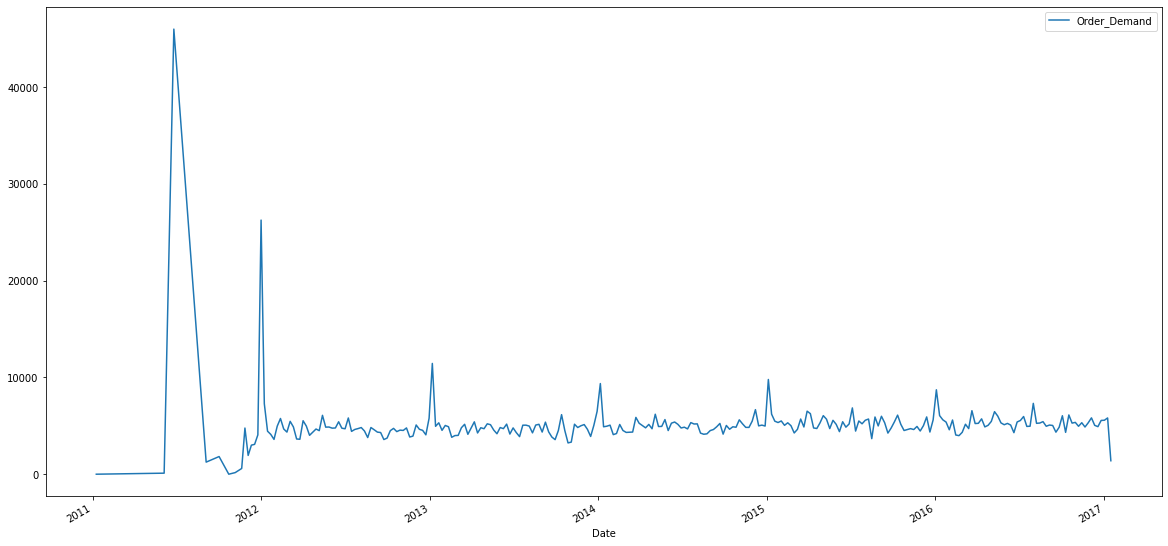

In [17]:
series.plot(figsize=(20,10))
show()

***Seasonal Decompose*** <br>
For average weekly demand for all category and product

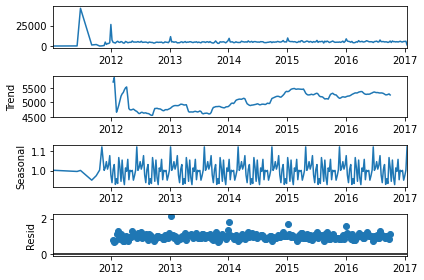

In [18]:
result = seasonal_decompose(series, model='multiplicative', period=30)
result.plot()
show()

The total weekly demand for all category and product for the trend and seasonality info extracted looks reasonable. Residual has too much information.
<br>***Let's try to select THE MOST DEMAND product and visualise the seasonal decompose***

In [19]:
df_top_5 = df[["Product_Category","Product_Code"]].groupby(["Product_Category","Product_Code"])["Product_Category","Product_Code"] \
    .size() \
    .nlargest(5)

df_top_5.head()

Product_Category  Product_Code
19                1359            16936
                  1295            10575
                  1378             9770
1                 620              9428
19                1286             8888
dtype: int64

***Lets use product category 19 and code 1359!***

In [20]:
df_19_1359 = df.loc[ (df["Product_Code"]==1359) & (df["Product_Category"]==19)]
df_19_1359 = df_19_1359[["Order_Demand","Date"]]
df_19_1359.reset_index(drop=True)
df_19_1359.set_index("Date",inplace=True)

# Get the weekly mean
df_19_1359_w = df_19_1359.resample('W').mean()
df_19_1359_w.dropna(inplace=True)
df_19_1359_w = df_19_1359_w.loc[df_19_1359_w["Order_Demand"] > 0]

df_19_1359_w.head()

,Order_Demand
Date,
2012-01-08,38277.777778
2012-01-15,21416.666667
2012-01-22,22207.792208
2012-01-29,27833.333333
2012-02-05,32020.408163


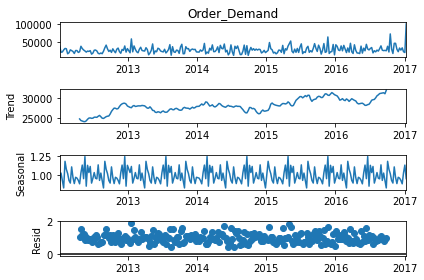

In [21]:
result = seasonal_decompose(df_19_1359_w["Order_Demand"], model='multiplicative', period=30)
result.plot()
show()

The average weekly demand for category 19 and product 1359 seems similar to the average weekly demand of all category and product. As you can see the above, the seasonality occurs yearly.

## Build one or more forecasting models to determine the demand for a particular product using the other columns as features

***Let's start with fbprophet for category 19 and product code 1359*** <br>
Rename the df_19_1359  columns with only ds and y columns

In [22]:
# Must have ds and y columns only
df_prophet = df_19_1359_w.copy()
df_prophet.reset_index(drop=False, inplace=True)
df_prophet.rename(columns={
    "Date": "ds",
    "Order_Demand": "y"
}, inplace=True)
df_prophet.head()

,ds,y
0,2012-01-08,38277.777778
1,2012-01-15,21416.666667
2,2012-01-22,22207.792208
3,2012-01-29,27833.333333
4,2012-02-05,32020.408163


In [23]:
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=730)
future.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
984,2019-01-04
985,2019-01-05
986,2019-01-06
987,2019-01-07
988,2019-01-08


In [24]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
984,2019-01-04,40128.113371,28877.369830,52020.518362
985,2019-01-05,40329.257641,28111.945245,51678.388397
986,2019-01-06,40487.507270,27956.400221,53221.888577
987,2019-01-07,40605.722260,28053.842283,53221.100815
988,2019-01-08,40687.333776,28725.241152,52722.113889


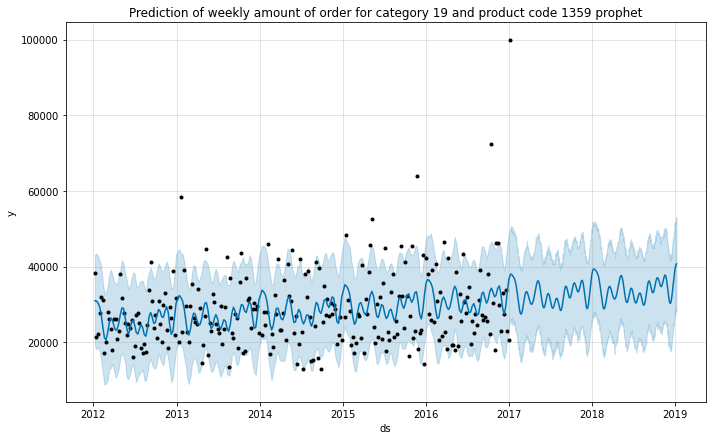

In [25]:
model.plot(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
title("Prediction of weekly amount of order for category 19 and product code 1359 prophet")
show()

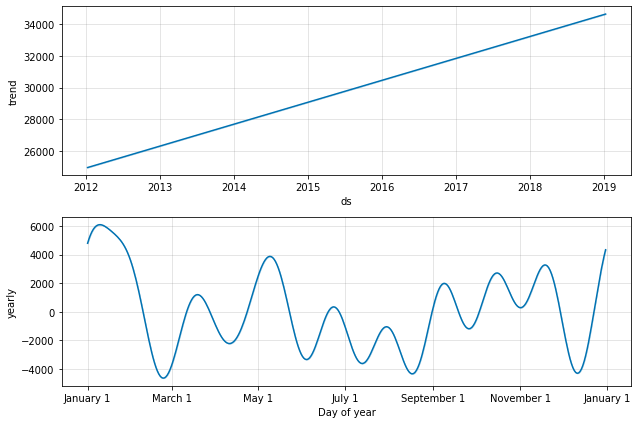

In [26]:
model.plot_components(forecast)
show()

From the prophet, we can see the increase of demand for category 19 and product code 1359

***Lets try ARIMA with 80% train 20% test for category 19 and product code 1359***<br>
Split the dataset category 19 and product code 1359 into 80% test and 20% test

In [27]:
def time_series_train_test_split(value_1d, train_size):
    X = value_1d
    size = int(len(X) * train_size)
    train, test = X[0:size], X[size:len(X)]
    return train, test

series_19_1359_w = df_19_1359_w.copy().values
train, test = time_series_train_test_split(series_19_1359_w, 0.8)

***Find the best (p,d,q) by comparing the AIC. Lower AIC is better.***

NOTE:We choose AIC because it simpler than DIC, WAIC, LOO-CV. <br>
And also, because we hae smaller amount of data.

In [28]:

p = d = q = range(0,2)
pdq = list(product(p, d, q))
# Seasonal order is 7(weekly) as we already know from seasonal_decompose
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]


We append all the aic values to the list

In [29]:
def get_aic_list(value_1d):
    aic_list = []
    for pdq_element in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = ARIMA(value_1d,
                            order=pdq_element,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

                results = model.fit()
                aic_list.append((pdq_element, seasonal_order, results.aic))
            except:
                continue
    return aic_list


Find the min AIC

In [30]:
aic_list = get_aic_list(train)
min_aic_tuple = min(aic_list, key = lambda i: i[2])
order = min_aic_tuple[0]
seasonal_order = min_aic_tuple[1]
print(f"The (p,d,q) order of train is {order}")
print(f"The (p,d,q,12) seasonal order of train is {seasonal_order}")
print(f"The minimum AIC vlaue of train is {min_aic_tuple[2]}")

The (p,d,q) order of train is (1, 0, 1)
The (p,d,q,12) seasonal order of train is (1, 1, 1, 12)
The minimum AIC vlaue of train is 3862.9506222607483


In [31]:
list_of_train_values = [x for x in train]
output = []
for i in range(len(test)):
    model = ARIMA(list_of_train_values, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit().forecast()
    yhat = result[0]
    output.append(yhat)
    
    list_of_train_values.append(test[i])

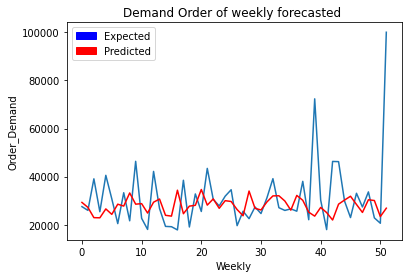

In [32]:
plot(test)
plot(output, color='red')
blue_patch = Patch(color='blue', label='Expected')
red_patch = Patch(color='red', label='Predicted')
legend(handles=[blue_patch,red_patch])
title('Demand Order of weekly forecasted ')
ylabel("Order_Demand")
xlabel("Weekly")
show()

The predicted seems to match expected on certain points!<br>
***ARIMA with weekly data for category 19 and product code 1359***

In [33]:
# Intiliase weekly data
series_19_1359_w = df_19_1359.resample("W").mean()

In [34]:
# NOTE: The top part is only the minimum aic for train set
# This is all the dataset
aic_list = get_aic_list(series_19_1359_w)
min_aic_tuple = min(aic_list, key = lambda i: i[2])
order = min_aic_tuple[0]
seasonal_order = min_aic_tuple[1]
print(f"The (p,d,q) order of all is {order}")
print(f"The (p,d,q,12) seasonal order of all is {seasonal_order}")
print(f"The minimum AIC vlaue of all is {min_aic_tuple[2]}")

The (p,d,q) order of all is (1, 0, 1)
The (p,d,q,12) seasonal order of all is (0, 1, 1, 12)
The minimum AIC vlaue of all is 5009.470308350376


In [35]:
model = ARIMA(series_19_1359_w , order=order , seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                     Order_Demand   No. Observations:                  262
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -2500.735
Date:                          Sun, 11 Oct 2020   AIC                           5009.470
Time:                                  10:07:51   BIC                           5023.326
Sample:                              01-08-2012   HQIC                          5015.056
                                   - 01-08-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9188      0.026     35.507      0.000       0.868       0.969
ma.L1         -0.9451      0.043    -21.873      0.000      -1.030      -0.860
ma.S.L12      -0.7825      0.053    -14.741      0.000      -0.887      -0.678
sigma2      1.631e+08   9.04e-11   1.81e+18      0.000    1.63e+08    1.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.59   Jarque-Bera (JB):               564.45
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+33. Standard errors may be unstable.
"""

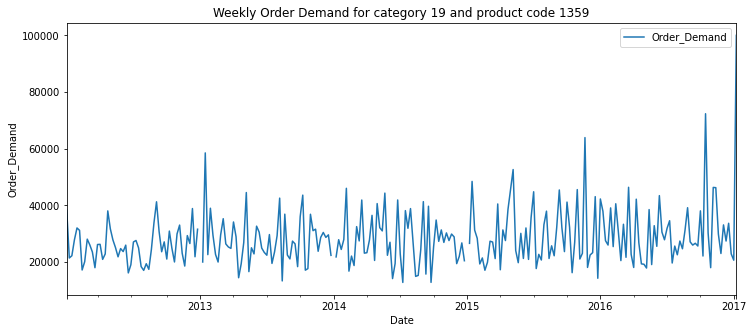

In [36]:
series_19_1359_w.plot(figsize=(12,5))
title("Weekly Order Demand for category 19 and product code 1359")
ylabel("Order_Demand")
show()

In [37]:
pred = results.get_prediction(start=to_datetime('2013-01-06'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()
pred_ci.head()

,lower Order_Demand,upper Order_Demand
Date,,
2013-01-06,5485.305197,55936.829170
2013-01-13,1363.752733,51796.530893
2013-01-20,-2516.758107,47896.818924
2013-01-27,-1146.885449,49251.118979
2013-02-03,-954.399070,49431.170386


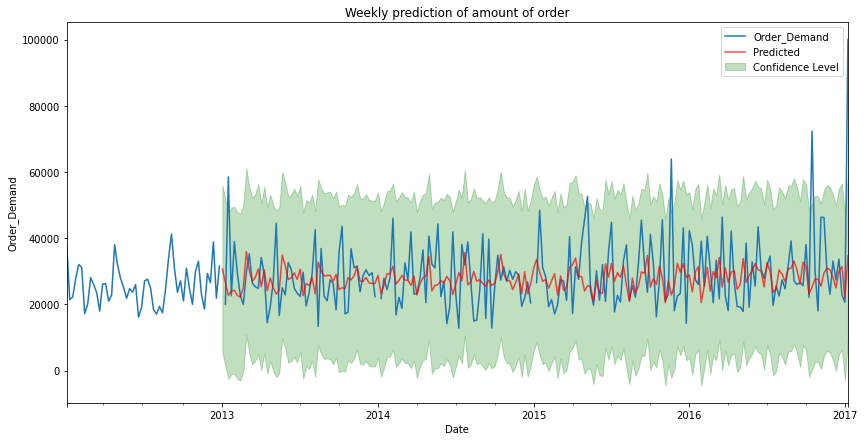

In [38]:
ax = series_19_1359_w['2012':].plot(label='Expected')
pred.predicted_mean.plot(ax=ax, label='Predicted', color='red', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:,1], pred_ci.iloc[:,0], color='green', alpha=.25, label="Confidence Level")
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
title("Weekly prediction of amount of order")
legend()
show()

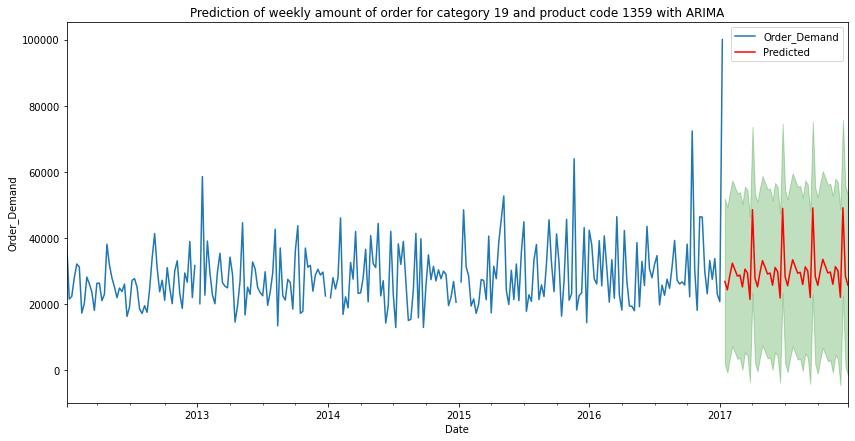

In [39]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = series_19_1359_w.plot(label='Expected', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, color='red', label='Predicted')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
title("Prediction of weekly amount of order for category 19 and product code 1359 with ARIMA")
legend()
show()

# Summary
- The prediction model prophet and ARIMA seems to work well because both of the model's prediction have a lot of points that intersect with expected value
- Both model future prediction amount of order is also very possible and makes sense